# **CIS 4190/5190 Spring 2023 - Homework 5**

**Before starting, you must click on the "Copy To Drive" option in the top bar. Go to File --> Save a Copy to Drive. This is the master notebook so <u>you will not be able to save your changes without copying it </u>! Once you click on that, make sure you are working on that version of the notebook so that your work is saved** 

In [117]:
# Restart the runtime after running this cell everytime you open the notebook
!pip install dill

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [118]:
import random 
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from numpy.linalg import *
from sklearn import preprocessing
np.random.seed(42)  # don't change this line

import base64

# **1. [20 pts] Image Classification using CNN**

#### **Import libraries**

In [125]:
if NOTEBOOK:
    import os
    import numpy as np
    import pandas as pd
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    import torch.optim as optim
    from torchvision import transforms
    from torchvision.transforms import ToTensor
    from torch.utils.data import Dataset, DataLoader
    from PIL import Image
    import matplotlib.pyplot as plt

#### **Set the random seed**

In [126]:
if NOTEBOOK:
    np.random.seed(0)
    torch.manual_seed(0)

#### **Set GPU**

In [127]:
# Make sure you're using cuda (GPU) by checking the hardware accelerator under Runtime -> Change runtime type
if NOTEBOOK:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("We're using:", device)

We're using: cuda


#### **Download and extract the data**

In [128]:
%%capture
if NOTEBOOK:
    !pip install -U gdown

In [129]:
if NOTEBOOK:
    !gdown 1vacRphjb47LXifcd3F2xlsOTKR0R_LiF

Downloading...
From (uriginal): https://drive.google.com/uc?id=1vacRphjb47LXifcd3F2xlsOTKR0R_LiF
From (redirected): https://drive.google.com/uc?id=1vacRphjb47LXifcd3F2xlsOTKR0R_LiF&confirm=t&uuid=e5209960-b6a8-44aa-a77b-6ea2535ee2f4
To: /content/supertuxkart_data.zip
100% 46.2M/46.2M [00:01<00:00, 41.1MB/s]


In [130]:
%%capture
if NOTEBOOK:
    !yes N | unzip "/content/supertuxkart_data.zip" -d "/content"

## **1.1. Dataset class implementation**

In this section, you will be training, validating and testing a CNN model to classify images of objects from a car racing video game called SuperTuxKart. There are 6 classes of objects: kart is 1, pickup is 2, nitro is 3, bomb is 4 and projectile 5. The background class (all other images) is assigned the label 0. First, you need to load data in a way that PyTorch can deal with easily. We will lean on PyTorch’s `Dataset` class to do this. 

Complete the `STKDataset` class that inherits from `Dataset`.

1. `__init__` is a constructor, and would be the natural place to perform operations common to the full dataset, such as parsing the labels and image paths.
2. The `__len__` function should return the size of the dataset, i.e., the number of samples.
3. The `__getitem__` function should return a python tuple of (image, label). The image should be a torch.Tensor of size (3, 64, 64) and the label should be an int.

The labels of the images under a particular folder (`train/` or `val/`) are stored in the same folder as `labels.csv`. Read the `labels.csv` file using `pandas` to understand what it looks like before proceeding. There is also a `labels.csv` in the `test/` folder. That would only contain the file names of the test samples.

In [131]:
check_labels = pd.read_csv("train/labels.csv")
check_labels.head()

,file,label,track
0,00001.jpg,background,abyss
1,00002.jpg,background,abyss
2,00003.jpg,background,abyss
3,00004.jpg,background,abyss
4,00005.jpg,background,abyss


In [132]:
if NOTEBOOK:
    ENCODING_TO_LABELS = {0: "background",
                        1: "kart",
                        2: "pickup",
                        3: "nitro",
                        4: "bomb",
                        5: "projectile"}

    LABELS_TO_ENCODING = {"background": 0,
                        "kart": 1,
                        "pickup": 2,
                        "nitro": 3,
                        "bomb": 4,
                        "projectile": 5}

In [133]:
if NOTEBOOK:
    
    class STKDataset(Dataset):

        def __init__(self, image_path, transform=None):
            self.image_path = image_path
            self.labels = pd.read_csv(image_path + "/labels.csv")
            self.transform = transform

        def __len__(self):
            
            # STUDENT TODO START: Return the number of samples in the dataset
            return len(self.labels)
            # STUDENT TODO END

        def __getitem__(self, idx):
            
            if torch.is_tensor(idx):
                idx = idx.tolist()

            # STUDENT TODO START: Create the path to each image by joining the root path with the name of the file as found in labels.csv
            img_name = os.path.join(self.image_path, self.labels.iloc[idx,0])
            # STUDENT TODO END

            # Read the image from the file path
            image = Image.open(img_name)
            # Transform the image using self.transform
            if self.transform:
                image = self.transform(image)

            if "label" in self.labels.columns:
                # STUDENT TODO START: Extract label name and encode it using the LABELS_TO_ENCODING dictionary
                label = LABELS_TO_ENCODING[self.labels.iloc[idx,1]]
                # STUDENT TODO END
                sample = (image, label)
            else:
                sample = (image)
            return sample

In [134]:
if NOTEBOOK:
    # STUDENT TODO START: Use transforms.Compose to transform the image such that every pixel takes on a value between -1 and 1
    # Hint: Refer to transforms.ToTensor() and transforms.Normalize() 
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(0.5,0.5)])
    # STUDENT TODO END

    train_dataset = STKDataset(image_path="train", transform=transform)
    val_dataset = STKDataset(image_path="val", transform=transform)
    test_dataset = STKDataset(image_path="test", transform=transform)

#### **Visualization**

The following cell visualizes the data as a sanity check for your implementation of the `STKDataset` class.

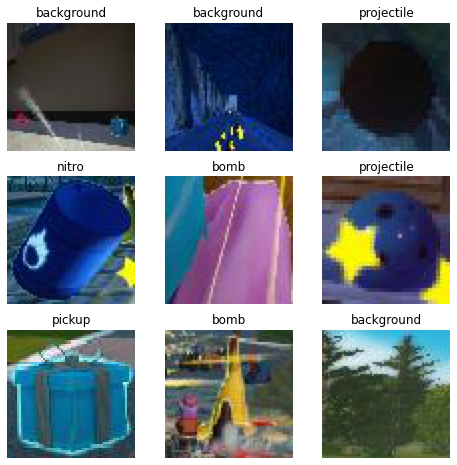

In [135]:
if NOTEBOOK:
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    torch.manual_seed(0)
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
        img, label = train_dataset[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(ENCODING_TO_LABELS[label])
        plt.axis("off")
        plt.imshow(img.permute(1, 2, 0)*0.5 + 0.5)
    plt.show()

#### **Data loaders**

In [166]:
if NOTEBOOK:
    # STUDENT TODO START: Create data loaders for training, validation, and test sets each having a batch size of 64. 
    # Set shuffle to be True for training and validation data loaders, False for test data loader.
    train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    # STUDENT TODO END

## **1.2. CNN architecture**

Your goal is to devise a CNN that passes the threshold accuracy (80%) on the test set. You get full score (20 pts) if you get at least 80% test set accuracy and 0 if you get 30% or below. The score varies linearly between 0 and 20 for accuracies between 30% and 80%. 

There are several decisions that you take in building your CNN including but not limited to:

- the number of convolutional layers
- the kernel size, stride, padding and number of out channels for each convolutional layer
- number of fully connected layers
- number of nodes in each fully connected layer

You are free to decide the architecture. To make your search easier, we recommend you to use not more than four convolutional layers and four fully connected layers. We also suggest that you use the relu activation function between the layers.

In [167]:
if NOTEBOOK:
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            # STUDENT TODO START: Create the layers of your CNN here
            self.conv1 = nn.Conv2d(3,96,11,stride=4)
            self.conv2 = nn.Conv2d(96,256,5,stride=1,padding=2)
            self.conv3 = nn.Conv2d(256,384,3,stride=1,padding=1)
            self.conv4 = nn.Conv2d(384,384,3,stride=1,padding=1)
            self.conv5 = nn.Conv2d(384,256,3,stride=1,padding=1)
            self.fc1 = nn.Linear(4096, 4096)
            self.fc2 = nn.Linear(4096, 512)
            self.fc3 = nn.Linear(512, 6)

            # STUDENT TODO END

        def forward(self, x):
            # STUDENT TODO START: Perform the forward pass through the layers
            x = self.conv1(x)
            x = F.relu(x)
            x = F.max_pool2d(x, 3, stride=1)

            x = self.conv2(x)
            x = F.relu(x)
            x = F.max_pool2d(x, 3, stride=1)

            x = self.conv3(x)
            x = F.relu(x)

            x = self.conv4(x)
            x = F.relu(x)
            x = self.conv5(x)
            x = F.relu(x)
            x = F.max_pool2d(x, 3, stride=2)

            x = torch.flatten(x, 1)

            x = self.fc1(x)
            x = F.relu(x)

            x = self.fc2(x)
            x = self.fc3(x)

            return x
            # STUDENT TODO END

    # STUDENT TODO START: Create an instance of Net and move it to the GPU
    model = Net()
    model.to(device)
    # STUDENT TODO END

## **1.2. Training, validation, and testing**

In [168]:
if NOTEBOOK:
    # STUDENT TODO START: 
    # 1. Set the criterion to be cross entropy loss
    criterion = nn.CrossEntropyLoss()

    # 2. Experiment with different optimizers
    optimizer = optim.Adadelta(model.parameters(), lr=0.1)
    # STUDENT TODO END

In [169]:
if NOTEBOOK:

    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []

    # STUDENT TODO START:
    # Note that we have set the number of epochs to be 10. You can choose to increase or decrease the number of epochs.
    num_epochs = 10 
    for epoch in range(num_epochs):
        
        model.train()
        running_loss = 0.
        correct, total = 0, 0 
        
        for i, data in enumerate(train_dataloader, 0):

            inputs, labels = data
            # 1. Store the inputs and labels in the GPU
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # 2. Get the model predictions
            predictions = model(inputs)

            # 3. Zero the gradients out
            optimizer.zero_grad()

            # 4. Get the loss
            loss = criterion(predictions, labels)

            # 5. Calculate the gradients
            loss.backward()

            # 6. Update the weights
            optimizer.step()
                
            running_loss += loss.item()
            
            _, predicted = torch.max(predictions, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        train_loss.append(running_loss / len(train_dataloader))
        train_acc.append(correct/total)
                
        model.eval()
        running_loss = 0.
        correct, total = 0, 0 
        
        for i, data in enumerate(val_dataloader, 0):

            inputs, labels = data
            # 1. Store the inputs and labels in the GPU
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # 2. Get the model predictions
            predictions = model(inputs)


            # 3. Get the loss
            loss = criterion(predictions, labels)

            running_loss += loss.item()
            
            _, predicted = torch.max(predictions, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        validation_loss.append(running_loss / len(val_dataloader))
        validation_acc.append(correct/total)

        print(f"Epoch {epoch+1}:")

        print(f"Training Loss:", round(train_loss[epoch], 3))
        print(f"Validation Loss:", round(validation_loss[epoch], 3))
        
        print(f"Training Accuracy:", round(train_acc[epoch], 3))
        print(f"Validation Accuracy:", round(validation_acc[epoch], 3))

        print("------------------------------")

Epoch 1:
Training Loss: 1.255
Validation Loss: 1.512
Training Accuracy: 0.482
Validation Accuracy: 0.558
------------------------------
Epoch 2:
Training Loss: 0.553
Validation Loss: 0.722
Training Accuracy: 0.8
Validation Accuracy: 0.756
------------------------------
Epoch 3:
Training Loss: 0.393
Validation Loss: 0.624
Training Accuracy: 0.866
Validation Accuracy: 0.777
------------------------------
Epoch 4:
Training Loss: 0.305
Validation Loss: 0.475
Training Accuracy: 0.899
Validation Accuracy: 0.826
------------------------------
Epoch 5:
Training Loss: 0.243
Validation Loss: 0.349
Training Accuracy: 0.918
Validation Accuracy: 0.875
------------------------------
Epoch 6:
Training Loss: 0.198
Validation Loss: 1.0
Training Accuracy: 0.933
Validation Accuracy: 0.737
------------------------------
Epoch 7:
Training Loss: 0.176
Validation Loss: 0.803
Training Accuracy: 0.942
Validation Accuracy: 0.744
------------------------------
Epoch 8:
Training Loss: 0.146
Validation Loss: 0.814

KeyboardInterrupt: ignored

In [170]:
if NOTEBOOK:

    model.eval()

    test_predictions = np.array([])

    for i, data in enumerate(test_dataloader, 0):

        inputs = data
        # STUDENT TODO START:
        # 1. Store the inputs in the GPU
        inputs = inputs.to(device)
        
        # 2. Get the model predictions
        predictions = model(inputs)
        # STUDENT TODO END
    
        _, predicted = torch.max(predictions, 1)

        test_predictions = np.concatenate((test_predictions, predicted.detach().cpu().numpy()))

In [171]:
# PennGrader Grading Cell
if NOTEBOOK:
    grader.grade(test_case_id = 'test_cnn_predictions', answer = test_predictions)

Correct! You earned 20/20 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Download the .ipynb notebook and submit on Gradescope.